In [113]:
# ===== 0) CONFIG =====
GEOJSON_PATH =  "../data/abm_households_newcastle.geojson" 
CLIM_PATH    =  "../data/ncc_2t_timeseries_2010_2039.parquet"
LOCAL_TZ     = "Europe/London"       # used by model.local_hour()
N_STEPS      = 48                    # hours to simulate


In [128]:
# ===== 1) Imports & module hygiene =====
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
from household_energy.climate import ClimateField
from household_energy.model import EnergyModel

In [116]:

import os, sys, time, math, inspect, warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
from pathlib import Path



In [117]:
# ===== 2) Validate climate parquet (rectangular T×P) =====
ok_summary = ClimateField.validate_parquet(CLIM_PATH, verbose=True, return_summary=True)
assert ok_summary["rectangular"], "Climate parquet is not rectangular – fix upstream or filter timestamps."


[Climate parquet check]
  File: ../data/ncc_2t_timeseries_2010_2039.parquet
  Rows: 3,506,400 | T: 175,320 | P: 20 | T×P: 3,506,400
  Duplicates dropped: 9120
  Rows per timestamp → min/median/max: 20/20/20
  ✅ Rectangular grid (full T×P).


In [118]:
# ===== 3) Load geometry & ensure EPSG:4326 =====
gdf = gpd.read_file(GEOJSON_PATH)
if gdf.crs is None:
    raise ValueError("GeoJSON has no CRS. Set one (e.g., EPSG:4326) before running.")
if gdf.crs.to_string().upper() != "EPSG:4326":
    gdf = gdf.to_crs(4326)
    
# keep only needed cols (robust to missing optional cols)
#keep = ["fid","geometry","property_type","sap_rating","energy_demand"]
#for c in keep:
#    if c not in gdf.columns: gdf[c] = np.nan
#gdf = gdf[keep].copy()

In [119]:
# ===== 4) Choose a start time inside the parquet & show span =====
clim_meta = pd.read_parquet(CLIM_PATH, columns=["timestamp"]).sort_values("timestamp")
t0 = pd.to_datetime(clim_meta["timestamp"].iloc[0], utc=True)           # first hour
t1 = pd.to_datetime(clim_meta["timestamp"].iloc[-1], utc=True)          # last hour
print(f"Climate time span: {t0} → {t1}  (n={clim_meta['timestamp'].nunique()} hours)")


Climate time span: 2020-01-01 00:00:00+00:00 → 2039-12-31 23:00:00+00:00  (n=175320 hours)


In [130]:
# ===== 5) Build model + climate =====
t_build = time.perf_counter()
m = EnergyModel(
    gdf=gdf,
    climate_parquet=CLIM_PATH,
    climate_start=t0,        # align to first climate hour
    local_tz=LOCAL_TZ,
    level_scale=1.0,                  # keep raw level for now
    collect_agent_level=True,        # <-- critical for long 
)
t_build = time.perf_counter() - t_build
print(f"Model init time: {t_build:.2f}s  | households={len(m.household_agents)}, persons={len(m.person_agents)}")

# Small sanity: each house mapped to a climate index
assert m._clim_idx_per_house is not None and len(m._clim_idx_per_house) == len(m.household_agents)


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy_abm/household_energy/model.py:74: RuntimeWarning: Mean of empty slice
  self.energy_by_type: Dict[str, float] = {t: 0.0 for t in PROPERTY_TYPES}


Model init time: 84.69s  | households=134503, persons=269006


In [131]:
# ===== 6) Run a short simulation =====
t_run = time.perf_counter()
for _ in range(N_STEPS):
    m.step()
t_run = time.perf_counter() - t_run
print(f"Ran {N_STEPS} hours in {t_run:.2f}s")

Ran 48 hours in 20.21s


In [126]:
import pandas as pd
from household_energy.climate import ClimateField

cf = ClimateField(CLIM_PATH)
total_hours = len(cf.times)         # full parquet span
print("Total climate hours:", total_hours)


Total climate hours: 175320


In [127]:
# ===== 7) Pull outputs =====
agent_df = m.datacollector.get_agent_vars_dataframe()
model_df = m.datacollector.get_model_vars_dataframe()

display(model_df.tail(5))
display(agent_df.head(8))

,mid-terraced house,semi-detached house,small block of flats/dwelling converted in to flats,large block of flats,block of flats,end-terraced house,detached house,flat in mixed use building,high,medium,low,total_energy,cumulative_energy,ambient_mean_tempC,climate_hour_index
44,164269.106839,197860.623936,108777.585976,52528.599124,28061.828417,74145.036809,93063.113015,25915.226077,175147.05,134595.0,107348.4,744621.120193,3.260479e+07,10.346463,44
45,163675.347497,197129.009706,108379.473888,52337.301464,27935.507830,73851.847088,92809.913119,25824.418057,175147.05,134595.0,107348.4,741942.818649,3.334673e+07,10.545589,45
46,163030.200213,196361.708067,107870.220074,52086.414053,27792.062621,73548.326552,92525.131170,25711.387832,175147.05,134595.0,107348.4,738925.450583,3.408566e+07,10.769924,46
47,162404.994955,195664.013389,107333.797289,51816.107107,27651.769515,73254.119869,92313.389883,25577.479714,175147.05,134595.0,107348.4,736015.671722,3.482168e+07,10.986259,47
48,162536.530865,195865.038179,107377.529470,51826.431952,27679.290722,73323.871407,92389.208285,25578.982491,175147.05,134595.0,107348.4,736576.883371,3.555825e+07,10.944534,48


agent_type  energy  energy_consumption  ambient_tempC  \
Step AgentID                                                            
0    4510000000  household     0.0                 0.0            NaN   
     4510000001  household     0.0                 0.0            NaN   
     4510000002  household     0.0                 0.0            NaN   
     4510000003  household     0.0                 0.0            NaN   
     4510000004  household     0.0                 0.0            NaN   
     4510000005  household     0.0                 0.0            NaN   
     4510000006  household     0.0                 0.0            NaN   
     4510000007  household     0.0                 0.0            NaN   

                 climate_heating_kWh  climate_cooling_kWh  \
Step AgentID                                                
0    4510000000                  0.0                  0.0   
     4510000001                  0.0                  0.0   
     4510000002                  0.0                  0.0   
     4510000003                  0.0                  0.0   
     4510000004                  0.0                  0.0   
     4510000005                  0.0                  0.0   
     4510000006                  0.0                  0.0   
     4510000007                  0.0                  0.0   

                       property_type  sap_rating  annual_energy_kwh  \
Step AgentID                                                          
0    4510000000       detached house        70.0       11035.982917   
     4510000001   mid-terraced house        70.0        9098.737124   
     4510000002   end-terraced house        70.0       10838.954846   
     4510000003  semi-detached house        70.0        9582.655143   
     4510000004  semi-detached house        70.0       16534.247812   
     4510000005   end-terraced house        70.0       15994.974705   
     4510000006  semi-detached house        70.0       16735.177429   
     4510000007  semi-detached house        70.0       16698.533730   

                 floor_area_m2  ... cwi_flag swi_flag loft_ins_flag  \
Step AgentID                    ...                                   
0    4510000000         159.57  ...      0.0      0.0           0.0   
     4510000001          75.00  ...      0.0      0.0           0.0   
     4510000002          86.00  ...      0.0      0.0           0.0   
     4510000003          85.39  ...      0.0      0.0           0.0   
     4510000004          85.58  ...      0.0      0.0           0.0   
     4510000005          90.00  ...      0.0      0.0           0.0   
     4510000006          85.58  ...      0.0      0.0           0.0   
     4510000007          93.00  ...      0.0      0.0           0.0   

                 floor_ins_flag  glazing_flag is_off_gas is_electric_heating  \
Step AgentID                                                                   
0    4510000000             0.0           0.0        0.0                 0.0   
     4510000001             0.0           0.0        0.0                 0.0   
     4510000002             0.0           0.0        0.0                 0.0   
     4510000003             0.0           0.0        0.0                 0.0   
     4510000004             0.0           0.0        0.0                 0.0   
     4510000005             0.0           0.0        0.0                 0.0   
     4510000006             0.0           0.0        0.0                 0.0   
     4510000007             0.0           0.0        0.0                 0.0   

                 is_gas  is_oil  is_solid_fuel  
Step AgentID                                    
0    4510000000     1.0     0.0            0.0  
     4510000001     1.0     0.0            0.0  
     4510000002     1.0     0.0            0.0  
     4510000003     1.0     0.0            0.0  
     4510000004     1.0     0.0            0.0  
     4510000005     1.0     0.0            0.0  
     4510000006     1.0     0.0            0.0  
     45100

Households at step 48: 91,947
       ambient_tempC  climate_heating_kWh  climate_cooling_kWh  \
count      91947.000            91947.000              91947.0   
mean          10.937                0.756                  0.0   
std            0.083                0.008                  0.0   
min           10.733                0.750                  0.0   
25%           10.902                0.752                  0.0   
50%           10.977                0.752                  0.0   
75%           10.977                0.760                  0.0   
max           10.997                0.777                  0.0   

       energy_consumption  
count           91947.000  
mean                6.719  
std                 2.440  
min                 2.511  
25%                 5.273  
50%                 6.201  
75%                 7.521  
max               156.661  


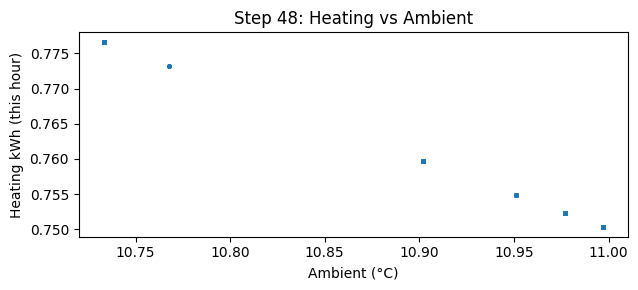

                                                    climate_heating_kWh  \
property_type                                                             
semi-detached house                                               0.758   
end-terraced house                                                0.758   
detached house                                                    0.757   
mid-terraced house                                                0.756   
block of flats                                                    0.755   
small block of flats/dwelling converted in to f...                0.754   
flat in mixed use building                                        0.753   
large block of flats                                              0.753   

                                                    climate_cooling_kWh  \
property_type                                                             
semi-detached house                                                 0.0   
end-terraced house      

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_83467/1185883615.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


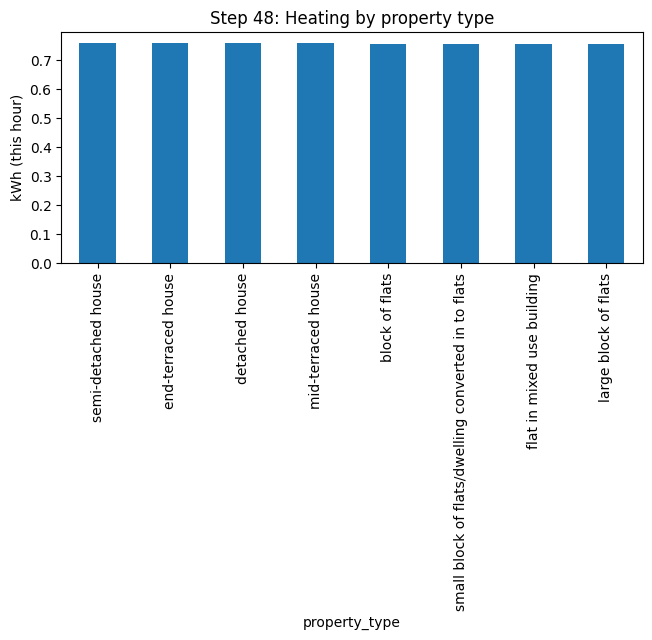

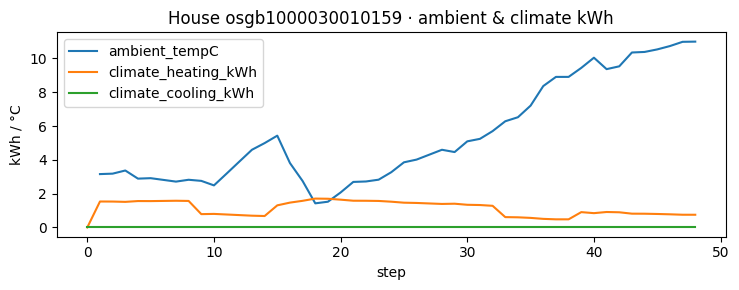

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Narrow to last-step households (fast)
adf = m.datacollector.get_agent_vars_dataframe()
adf.index = adf.index.set_names(["step","AgentID"])
last_step = adf.index.get_level_values("step").max()

house_last = adf.loc[(last_step, slice(None)), :]
if "agent_type" in house_last.columns:
    house_last = house_last[house_last["agent_type"] == "household"]
else:
    # fallback if you remove agent_type later: households have ambient_tempC not NaN
    house_last = house_last[house_last["ambient_tempC"].notna()]

# basic sanity
print(f"Households at step {last_step}: {len(house_last):,}")
print(house_last[["ambient_tempC","climate_heating_kWh","climate_cooling_kWh","energy_consumption"]]
      .describe().round(3))

# 2) Quick plot: heating vs ambient (scatter, random 5k to keep it light)
sample = house_last.sample(min(5000, len(house_last)), random_state=0)
ax = sample.plot.scatter(x="ambient_tempC", y="climate_heating_kWh", s=5, alpha=0.4, figsize=(6.5,3))
ax.set_xlabel("Ambient (°C)"); ax.set_ylabel("Heating kWh (this hour)")
ax.set_title(f"Step {last_step}: Heating vs Ambient"); plt.tight_layout(); plt.show()

# 3) (Optional) add property_type for group-bys – pulled from the model
id_to_type = {h.unique_id: getattr(h, "property_type", "unknown") for h in m.household_agents}
house_last = house_last.assign(
    property_type=lambda df: df.index.get_level_values("AgentID").map(id_to_type)
)

# Group by property type (mean per house at this hour)
by_type = (house_last.groupby("property_type")[["climate_heating_kWh","climate_cooling_kWh","energy_consumption"]]
           .mean().sort_values("climate_heating_kWh", ascending=False))
print(by_type.head(10).round(3))

# Tiny bar chart of heating kWh by property type
ax = by_type["climate_heating_kWh"].plot(kind="bar", figsize=(7.5,3))
ax.set_ylabel("kWh (this hour)"); ax.set_title(f"Step {last_step}: Heating by property type")
plt.tight_layout(); plt.show()

# 4) One house over time (pick the first household id)
hid = house_last.index.get_level_values("AgentID")[0]
sub = adf.xs(hid, level="AgentID")
sub[["ambient_tempC","climate_heating_kWh","climate_cooling_kWh"]].plot(figsize=(7.5,3))
plt.title(f"House {hid} · ambient & climate kWh"); plt.ylabel("kWh / °C"); plt.tight_layout(); plt.show()


In [72]:
# ===== 8) Sanity checks on climate sampling =====
# A) ambient temps exist and are finite for most houses
amb_now = [getattr(h, "ambient_tempC", np.nan) for h in m.household_agents]
print("Current hour:", m.current_hour, "| sample ambient temps:", amb_now[:5])
assert np.isfinite(amb_now).mean() > 0.95, "Too many NaNs in ambient temps."

# B) households vs persons split; check climate fields present for households
#    Mesa agent parquet index is (step, AgentID). Find household rows via 'energy==0' heuristic.
agent_df = agent_df.reset_index()
house_rows = (agent_df["energy"] == 0) & (agent_df["energy_consumption"] > 0)
assert house_rows.any(), "No household rows detected – reporters may be misconfigured."

need_cols = {"ambient_tempC","climate_heating_kWh","climate_cooling_kWh"}
missing_cols = need_cols - set(agent_df.columns)
assert not missing_cols, f"Missing expected agent reporters: {missing_cols}"

Current hour: 48 | sample ambient temps: [10.99725341796875, 10.97674560546875, 10.97674560546875, 10.97674560546875, 10.97674560546875]


In [73]:
# ===== 9) Degree-hour consistency test (per-house) =====
# pick an arbitrary household id
hid = agent_df.loc[house_rows, "AgentID"].unique()[0]
sub = agent_df[agent_df["AgentID"] == hid].copy()

# compute expected heating degree-hours given model setpoint
setpoint = float(m.heating_setpoint_C)
sub["hd"] = (setpoint - sub["ambient_tempC"]).clip(lower=0)
# For rows where hd>0, heating_kWh should be close to hd * slope (within noise)
slope = float(m.heating_slope_kWh_per_deg)
mask = sub["hd"] > 0
if mask.sum() >= 5:
    ratio = (sub.loc[mask, "climate_heating_kWh"] / sub.loc[mask, "hd"]).median()
    print(f"Median heating_kWh/hd ratio: {ratio:.3f} (model slope={slope:.3f})")
    assert 0.8*slope <= ratio <= 1.2*slope, "Heating slope not reflected in kWh (±20% tolerance)."
else:
    print("Not enough heating hours in this window to validate slope (hd>0).")

# Cooling check is analogous (optional)
thr = float(m.cooling_threshold_C)
sub["cd"] = (sub["ambient_tempC"] - thr).clip(lower=0)
maskc = sub["cd"] > 0
if maskc.sum() >= 5:
    ratio_c = (sub.loc[maskc, "climate_cooling_kWh"] / sub.loc[maskc, "cd"]).median()
    print(f"Median cooling_kWh/cd ratio: {ratio_c:.3f} (model slope={m.cooling_slope_kWh_per_deg:.3f})")



Median heating_kWh/hd ratio: 0.100 (model slope=0.100)


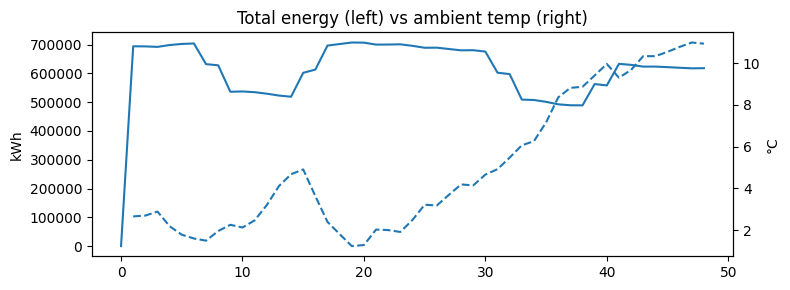

In [74]:
# ===== 10) Quick plots (robust) =====
import matplotlib.pyplot as plt

model_df = m.datacollector.get_model_vars_dataframe()

fig, ax1 = plt.subplots(figsize=(8,3))
model_df["total_energy"].plot(ax=ax1)
ax1.set_ylabel("kWh")
ax1.set_title("Total energy (left) vs ambient temp (right)")

ax2 = ax1.twinx()
model_df["ambient_mean_tempC"].plot(ax=ax2, linestyle="--")
ax2.set_ylabel("°C")

fig.tight_layout()
plt.show()


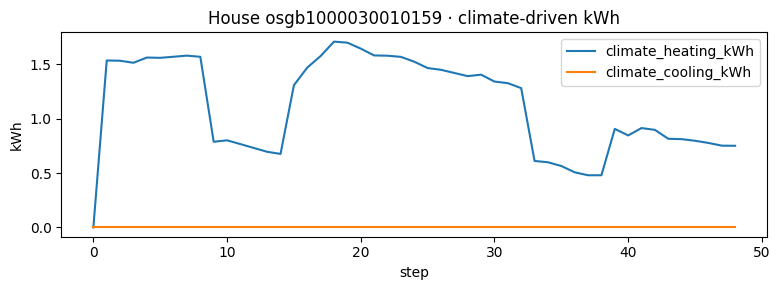

In [75]:
import pandas as pd

adf = m.datacollector.get_agent_vars_dataframe()
# make sure the index has names, then slice by AgentID without resetting
if isinstance(adf.index, pd.MultiIndex):
    adf.index = adf.index.set_names(["step","AgentID"])

# pick a house id (first one that has ambient temps)
hid = next(id_ for id_ in adf.index.get_level_values("AgentID").unique()
           if pd.notna(adf.xs(id_, level="AgentID")["ambient_tempC"]).any())

sub = adf.xs(hid, level="AgentID")

ax = sub[["climate_heating_kWh","climate_cooling_kWh"]].plot(figsize=(8,3))
ax.set_ylabel("kWh")
ax.set_title(f"House {hid} · climate-driven kWh")
ax.figure.tight_layout()
plt.show()


In [76]:
# ===== 11) Optional: verify local clock wiring =====
first_12 = [m.local_hour() - i % 24 for i in range(12)]
print("Local-hour drift check (should be mostly constant offsets):", first_12)

Local-hour drift check (should be mostly constant offsets): [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11]


In [132]:
# ===== 12) Performance summary =====
print(f"[Perf] init: {t_build:.2f}s | run({N_STEPS}h): {t_run:.2f}s | per-step: {t_run/max(1,N_STEPS):.4f}s")

[Perf] init: 84.69s | run(48h): 20.21s | per-step: 0.4210s


In [134]:
from pathlib import Path
import pandas as pd, time

def run_span(
    gdf,
    clim_path,
    outdir="results",
    start="2020-01-01",   # NEW: inclusive window start (UTC)
    end="2025-01-01",     # NEW: exclusive window end (UTC)
    flush_every_hours=24*14,
    collect_agent_level=False,        # NEW: passthrough
    agent_collect_every=24,           # NEW: passthrough
):
    outdir = Path(outdir); outdir.mkdir(exist_ok=True)
    from household_energy.climate import ClimateField
    from household_energy.model import EnergyModel

    cf = ClimateField(clim_path)

    # --- compute [start, end) indices into the climate timeline ---  # NEW
    start_utc = pd.to_datetime(start, utc=True)                       # NEW
    end_utc   = pd.to_datetime(end,   utc=True)                       # NEW
    i0 = cf.time_index_for(start_utc)                                 # NEW
    i1 = cf.time_index_for(end_utc)                                   # NEW
    if i1 <= i0:                                                      # NEW
        raise ValueError("Empty window: ensure end > start")          # NEW
    T = i1 - i0                                                       # NEW
    start_utc = pd.to_datetime(cf.times[i0], utc=True)                # NEW

    # --- build model aligned to *window start* ---------------------
    m = EnergyModel(
        gdf=gdf,
        climate_parquet=clim_path,
        climate_start=start_utc,          # align to first hour in window  # NEW
        local_tz="Europe/London",
        collect_agent_level=collect_agent_level,                        # NEW
        agent_collect_every=agent_collect_every,                        # NEW
    )

    t0 = time.perf_counter()
    for h in range(T):  # NEW: only hours within [start, end)
        m.step()
        if (h+1) % (24*7) == 0:
            elapsed = time.perf_counter() - t0
            print(f"progress: {h+1:,}/{T:,} hours  |  elapsed: {elapsed:.1f}s")

        # optional: flush partial hourly parquet (window-safe)        # NEW
        if (h+1) % flush_every_hours == 0:
            mdl = m.datacollector.get_model_vars_dataframe().copy()
            # Label by *hour start* so daily resamples land on the right day.
            mdl["hour_start_utc"] = start_utc + pd.to_timedelta(mdl.index - 1, unit="h")
            mdl = mdl.set_index("hour_start_utc").iloc[1:]            # drop t=0 snapshot
            mdl = mdl.loc[(mdl.index >= start_utc) & (mdl.index < end_utc)]
            mdl.to_parquet(outdir / "model_hourly_partial.parquet")

    # final save (hourly)
    mdl = m.datacollector.get_model_vars_dataframe().copy()
    mdl["hour_start_utc"] = start_utc + pd.to_timedelta(mdl.index - 1, unit="h")
    mdl = mdl.set_index("hour_start_utc").iloc[1:]                    # drop t=0 snapshot
    mdl = mdl.loc[(mdl.index >= start_utc) & (mdl.index < end_utc)]
    mdl.to_parquet(Path(outdir) / "model_hourly.parquet")

    # daily aggregates (sum energy, avg temps)
    daily = pd.DataFrame({
        "total_energy_kWh":       mdl["total_energy"].resample("D").sum(),
        "ambient_mean_tempC_avg": mdl["ambient_mean_tempC"].resample("D").mean(),
    })
    daily.to_parquet(Path(outdir) / "model_daily.parquet")
    return mdl, daily


In [135]:
# ===== WINDOWED RUNNER (2020–2024) =====
from pathlib import Path
import numpy as np
import pandas as pd
import time

OUTDIR = Path("results_2020_2024"); OUTDIR.mkdir(exist_ok=True)
HOURLY_OUT = OUTDIR / "model_hourly.parquet"
DAILY_OUT  = OUTDIR / "model_daily.parquet"

# --- climate meta (get indices for the window)
from household_energy.climate import ClimateField
cf = ClimateField(CLIM_PATH)

start_utc = pd.Timestamp("2020-01-01T00:00:00Z")
end_utc   = pd.Timestamp("2025-01-01T00:00:00Z")  # exclusive

i0 = cf.time_index_for(start_utc)
i1 = cf.time_index_for(end_utc)
if i1 <= i0:
    raise ValueError("Climate file does not cover 2020–2024.")
T_hours = i1 - i0
start_utc = pd.to_datetime(cf.times[i0], utc=True)  # align to exact grid

print(f"Window hours: {T_hours:,}  |  start: {start_utc}  |  end(excl): {end_utc}")

# --- build model (IMPORTANT: turn OFF agent-level collection for speed)
from household_energy.model import EnergyModel
t0 = time.perf_counter()
m = EnergyModel(
    gdf=gdf,
    climate_parquet=CLIM_PATH,
    climate_start=start_utc,       # begin at 2020-01-01 00 UTC
    local_tz="Europe/London",
    collect_agent_level=False,     # fast path
)
print(f"Init: {time.perf_counter()-t0:.2f}s | households={len(m.household_agents):,}, persons={len(m.person_agents):,}")

# --- run loop with lightweight progress
print_every_hours = 24 * 7  # weekly
t_run = time.perf_counter()
for h in range(T_hours):
    m.step()
    if (h+1) % print_every_hours == 0:
        print(f" progressed {h+1:,}/{T_hours:,} hours")
print(f"Run done: {time.perf_counter()-t_run:.1f}s")

# --- pull model-level hourly frame and label by *hour start*
mdl = m.datacollector.get_model_vars_dataframe().copy()
mdl["hour_start_utc"] = start_utc + pd.to_timedelta(mdl.index - 1, unit="h")
mdl = mdl.set_index("hour_start_utc").iloc[1:]                              # drop t=0 snapshot
mdl = mdl.loc[(mdl.index >= start_utc) & (mdl.index < end_utc)]             # clamp window

# save hourly (optional)
mdl.to_parquet(HOURLY_OUT)
print(f"Saved hourly model-level → {HOURLY_OUT}")

# --- make daily aggregates (sum energy; avg temps)
prop_cols   = [c for c in mdl.columns if c in m.energy_by_type.keys()]
wealth_cols = [c for c in ("high", "medium", "low") if c in mdl.columns]

daily = pd.DataFrame({
    "total_energy_kWh":       mdl["total_energy"].resample("D").sum(),
    "ambient_mean_tempC_avg": mdl["ambient_mean_tempC"].resample("D").mean(),
})

for c in prop_cols:
    daily[f"{c}_kWh"] = mdl[c].resample("D").sum()

for c in wealth_cols:
    daily[f"wealth_{c}_kWh"] = mdl[c].resample("D").sum()

daily = daily.loc["2020-01-01":"2024-12-31"]  # keep exactly 2020–2024 calendar days
daily.to_parquet(DAILY_OUT)
print(f"Saved daily aggregates → {DAILY_OUT}")

display(daily.head())
display(daily.tail())


Window hours: 43,848  |  start: 2020-01-01 00:00:00+00:00  |  end(excl): 2025-01-01 00:00:00+00:00


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy_abm/household_energy/model.py:74: RuntimeWarning: Mean of empty slice
  self.energy_by_type: Dict[str, float] = {t: 0.0 for t in PROPERTY_TYPES}


Init: 9.90s | households=134,503, persons=269,006
 progressed 168/43,848 hours
 progressed 336/43,848 hours
 progressed 504/43,848 hours
 progressed 672/43,848 hours
 progressed 840/43,848 hours
 progressed 1,008/43,848 hours
 progressed 1,176/43,848 hours
 progressed 1,344/43,848 hours
 progressed 1,512/43,848 hours
 progressed 1,680/43,848 hours
 progressed 1,848/43,848 hours
 progressed 2,016/43,848 hours
 progressed 2,184/43,848 hours
 progressed 2,352/43,848 hours
 progressed 2,520/43,848 hours
 progressed 2,688/43,848 hours
 progressed 2,856/43,848 hours
 progressed 3,024/43,848 hours
 progressed 3,192/43,848 hours
 progressed 3,360/43,848 hours
 progressed 3,528/43,848 hours
 progressed 3,696/43,848 hours
 progressed 3,864/43,848 hours
 progressed 4,032/43,848 hours
 progressed 4,200/43,848 hours
 progressed 4,368/43,848 hours
 progressed 4,536/43,848 hours
 progressed 4,704/43,848 hours
 progressed 4,872/43,848 hours
 progressed 5,040/43,848 hours
 progressed 5,208/43,848 hours

,total_energy_kWh,ambient_mean_tempC_avg,mid-terraced house_kWh,semi-detached house_kWh,small block of flats/dwelling converted in to flats_kWh,large block of flats_kWh,block of flats_kWh,end-terraced house_kWh,detached house_kWh,flat in mixed use building_kWh,wealth_high_kWh,wealth_medium_kWh,wealth_low_kWh
hour_start_utc,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,1.853154e+07,2.631796,4.081798e+06,4.925507e+06,2.717374e+06,1.314561e+06,706086.478573,1.846661e+06,2.296077e+06,643479.690268,3.504870e+06,2743476.0,2.251442e+06
2020-01-02 00:00:00+00:00,1.702206e+07,7.589247,3.757180e+06,4.544727e+06,2.458633e+06,1.184061e+06,634427.209492,1.693070e+06,2.165680e+06,584281.519024,3.504870e+06,2743476.0,2.251442e+06
2020-01-03 00:00:00+00:00,1.767811e+07,5.339748,3.897893e+06,4.708078e+06,2.573882e+06,1.242047e+06,665733.753832,1.759348e+06,2.220079e+06,611047.902379,3.504870e+06,2743476.0,2.251442e+06
2020-01-04 00:00:00+00:00,1.740996e+07,6.334546,3.839874e+06,4.637981e+06,2.530252e+06,1.220706e+06,652965.715960,1.731645e+06,2.195124e+06,601407.219970,3.504870e+06,2743476.0,2.251442e+06
2020-01-05 00:00:00+00:00,1.708332e+07,7.408685,3.768947e+06,4.553305e+06,2.476794e+06,1.194223e+06,637494.737453,1.697503e+06,2.165936e+06,589118.040400,3.504870e+06,2743476.0,2.251442e+06


,total_energy_kWh,ambient_mean_tempC_avg,mid-terraced house_kWh,semi-detached house_kWh,small block of flats/dwelling converted in to flats_kWh,large block of flats_kWh,block of flats_kWh,end-terraced house_kWh,detached house_kWh,flat in mixed use building_kWh,wealth_high_kWh,wealth_medium_kWh,wealth_low_kWh
hour_start_utc,,,,,,,,,,,,,
2024-12-27 00:00:00+00:00,1.872471e+07,1.889499,4.122107e+06,4.965067e+06,2.759782e+06,1.337413e+06,715280.217271,1.864942e+06,2.305081e+06,655035.530574,3.504870e+06,2743476.0,2.251442e+06
2024-12-28 00:00:00+00:00,1.686839e+07,8.218038,3.723814e+06,4.504017e+06,2.435033e+06,1.171669e+06,627410.826153,1.676943e+06,2.150327e+06,579178.004401,3.504870e+06,2743476.0,2.251442e+06
2024-12-29 00:00:00+00:00,1.719560e+07,7.041996,3.794031e+06,4.585984e+06,2.491497e+06,1.200767e+06,642798.954166,1.710130e+06,2.178268e+06,592126.833031,3.504870e+06,2743476.0,2.251442e+06
2024-12-30 00:00:00+00:00,1.723151e+07,6.926768,3.801444e+06,4.593570e+06,2.498976e+06,1.204820e+06,644489.326437,1.713418e+06,2.180785e+06,594007.233832,3.504870e+06,2743476.0,2.251442e+06
2024-12-31 00:00:00+00:00,1.727995e+07,6.755049,3.812141e+06,4.607626e+06,2.505405e+06,1.207809e+06,646759.484707,1.718698e+06,2.186341e+06,595173.480829,3.504870e+06,2743476.0,2.251442e+06


In [83]:
display(daily.head())
display(daily.tail())

,total_energy_kWh,ambient_mean_tempC_avg,mid-terraced house_kWh,semi-detached house_kWh,small block of flats/dwelling converted in to flats_kWh,large block of flats_kWh,block of flats_kWh,end-terraced house_kWh,detached house_kWh,flat in mixed use building_kWh,wealth_high_kWh,wealth_medium_kWh,wealth_low_kWh
time_utc,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,1.475114e+07,2.497284,3.282958e+06,4.502908e+06,1.934412e+06,772822.317280,571507.663504,1.531518e+06,1.901097e+06,253921.932168,2.276958e+06,1796965.1,1.449598e+06
2020-01-02 00:00:00+00:00,1.447068e+07,7.205311,3.224623e+06,4.437039e+06,1.876175e+06,745055.116658,550094.188030,1.501232e+06,1.889751e+06,246711.167228,2.396384e+06,1889343.2,1.522439e+06
2020-01-03 00:00:00+00:00,1.479579e+07,5.513101,3.295218e+06,4.528819e+06,1.928064e+06,767336.732789,566663.240021,1.535021e+06,1.921269e+06,253397.256426,2.396384e+06,1889343.2,1.522439e+06
2020-01-04 00:00:00+00:00,1.465030e+07,6.338914,3.263118e+06,4.486404e+06,1.907246e+06,758423.241122,559590.646523,1.519248e+06,1.905479e+06,250787.993322,2.396384e+06,1889343.2,1.522439e+06
2020-01-05 00:00:00+00:00,1.444354e+07,7.342657,3.217440e+06,4.425855e+06,1.877628e+06,745867.741163,549612.266814,1.496560e+06,1.883675e+06,246906.432300,2.396384e+06,1889343.2,1.522439e+06


,total_energy_kWh,ambient_mean_tempC_avg,mid-terraced house_kWh,semi-detached house_kWh,small block of flats/dwelling converted in to flats_kWh,large block of flats_kWh,block of flats_kWh,end-terraced house_kWh,detached house_kWh,flat in mixed use building_kWh,wealth_high_kWh,wealth_medium_kWh,wealth_low_kWh
time_utc,,,,,,,,,,,,,
2039-12-28 00:00:00+00:00,1.608824e+07,-0.605118,3.576391e+06,4.892338e+06,2.132801e+06,855532.070469,631907.515661,1.669921e+06,2.049176e+06,280170.501150,2.396384e+06,1889343.2,1.522439e+06
2039-12-29 00:00:00+00:00,1.633082e+07,-1.716678,3.629665e+06,4.960650e+06,2.169492e+06,871549.414836,643943.552065,1.695446e+06,2.075270e+06,284807.092675,2.396384e+06,1889343.2,1.522439e+06
2039-12-30 00:00:00+00:00,1.626694e+07,-1.466422,3.615945e+06,4.942645e+06,2.158830e+06,867093.324116,640756.880512,1.688688e+06,2.069750e+06,283232.596807,2.396384e+06,1889343.2,1.522439e+06
2039-12-31 00:00:00+00:00,1.607974e+07,-0.571125,3.574705e+06,4.890265e+06,2.130300e+06,854615.091157,631449.471412,1.668956e+06,2.049878e+06,279571.017074,2.396384e+06,1889343.2,1.522439e+06
2040-01-01 00:00:00+00:00,7.185155e+05,-0.024147,1.596625e+05,2.177042e+05,9.624348e+04,38772.527323,28705.159624,7.472534e+04,9.008954e+04,12612.665986,1.194258e+05,92378.1,7.284120e+04


In [140]:
# ==== Compare gdf['energy_demand'] to DESNZ 2023 (elec + gas) ====
from pathlib import Path
import re
import numpy as np
import pandas as pd

LA  = "Newcastle upon Tyne"
YEAR = 2023

# locate the workbooks
XLSX_ELEC_CANDIDATES = [
    Path("../data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
]
XLSX_GAS_CANDIDATES = [
    Path("../data/Subnational_gas_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_gas_consumption_statistics_2005-2023.xlsx"),
]

XLSX_ELEC = next((p for p in XLSX_ELEC_CANDIDATES if p.exists()), None)
XLSX_GAS  = next((p for p in XLSX_GAS_CANDIDATES  if p.exists()), None)
assert XLSX_ELEC is not None, "DESNZ electricity workbook not found—update the path."
assert XLSX_GAS  is not None, "DESNZ gas workbook not found—update the path."

# --- DESNZ loader (robust to header wording; meters may be 'thousands') ---
def _header_row_for_sheet(xl, sheet: str) -> int:
    raw = xl.parse(sheet, header=None, nrows=50)
    for r in range(len(raw)):
        if any(isinstance(v,str) and v.strip().lower()=="local authority" for v in raw.iloc[r].tolist()):
            return r
    raise ValueError(f"Header row not found in sheet '{sheet}'")

def _norm_cols(cols): 
    return [re.sub(r"\s+"," ",str(c)).strip() for c in cols]

def _find_col(cols, *need):
    lc = [c.lower() for c in cols]
    for c, cl in zip(cols, lc):
        if all(tok.lower() in cl for tok in need): 
            return c
    return None

def desnz_metrics_for_year(xlsx_path: str | Path, la: str, year: int) -> dict:
    xl = pd.ExcelFile(xlsx_path); sheet = str(year)
    hdr = _header_row_for_sheet(xl, sheet)
    df  = xl.parse(sheet, header=hdr); df.columns = _norm_cols(df.columns)
    row = df[df["Local authority"].astype(str).str.lower().str.contains(la.lower())]
    if row.empty: 
        raise ValueError(f"LA '{la}' not found in {sheet}")

    # columns are robust to small wording variations
    col_tot_gwh = _find_col(df.columns, "total consumption", "all domestic", "gwh")
    if col_tot_gwh is None:
        # some years/sheets label as "domestic consumption (gwh)" or similar
        col_tot_gwh = _find_col(df.columns, "domestic", "consumption", "gwh")
    col_meters  = _find_col(df.columns, "number of meters", "all domestic")
    if col_meters is None:
        col_meters = _find_col(df.columns, "number of meters")  # fallback
    col_mean    = _find_col(df.columns, "mean consumption", "all domestic", "kwh")

    total_kwh = float(pd.to_numeric(row.iloc[0][col_tot_gwh], errors="coerce")) * 1_000_000.0
    meters_raw = float(pd.to_numeric(row.iloc[0][col_meters], errors="coerce")) if col_meters else np.nan
    meters_unit = (
        "thousands" 
        if (col_meters and re.search(r"thousand|000|\(000s\)|\(thousands\)", col_meters, re.I)) 
        else "count"
    )
    meters = meters_raw * (1000.0 if (col_meters and meters_unit == "thousands") else 1.0)

    if col_mean:
        mean_kwh = float(pd.to_numeric(row.iloc[0][col_mean], errors="coerce"))
    else:
        mean_kwh = total_kwh / meters if meters > 0 else np.nan

    return {
        "year": year, 
        "desnz_total_kWh": total_kwh, 
        "desnz_meters": meters, 
        "desnz_mean_kWh": mean_kwh,
        "_meter_col": col_meters, 
        "_meters_unit": meters_unit,
        "_total_col": col_tot_gwh, 
        "_mean_col": col_mean
    }

# --- Load DESNZ electricity + gas ---
D_elec = desnz_metrics_for_year(XLSX_ELEC, LA, YEAR)
D_gas  = desnz_metrics_for_year(XLSX_GAS,  LA, YEAR)

# Combined (Elec + Gas). For a single "per-home" mean, we default to using ELEC meters as denominator
# to match typical household counts (you can switch to gas meters if preferred).
D_combined = {
    "year": YEAR,
    "desnz_total_kWh": D_elec["desnz_total_kWh"] + D_gas["desnz_total_kWh"],
    "desnz_meters_elec": D_elec["desnz_meters"],
    "desnz_meters_gas":  D_gas["desnz_meters"],
    "desnz_mean_kWh_elec": D_elec["desnz_mean_kWh"],
    "desnz_mean_kWh_gas":  D_gas["desnz_mean_kWh"],
    "desnz_mean_kWh_per_home_using_elec_meters": (
        (D_elec["desnz_total_kWh"] + D_gas["desnz_total_kWh"]) / D_elec["desnz_meters"]
        if D_elec["desnz_meters"] > 0 else np.nan
    ),
    "desnz_mean_kWh_per_home_using_gas_meters": (
        (D_elec["desnz_total_kWh"] + D_gas["desnz_total_kWh"]) / D_gas["desnz_meters"]
        if D_gas["desnz_meters"] > 0 else np.nan
    ),
}

# --- ABM side from gdf (unchanged) ---
assert "energy_cal_kwh" in gdf.columns, "gdf must have 'energy_cal_kwh' (kWh/year)."
assert "property_type" in gdf.columns, "gdf must have 'PROPERTY_property_typeTYPE' (dwellings per polygon)."

E = pd.to_numeric(gdf["energy_cal_kwh"], errors="coerce")
N = pd.to_numeric(gdf["property_type"], errors="coerce").fillna(1).clip(lower=1).round()  # dwellings per polygon (>=1, int-like)

mask = E.notna() & N.notna()
E = E[mask]; N = N[mask]

abm_polygons   = int(len(E))
abm_eff_homes  = int(N.sum())

# A) INTERPRETATION: energy_demand is BUILDING TOTAL (kWh/yr per polygon)
A_total_kWh = float(E.sum())
A_mean_per_polygon = float(E.mean())
A_mean_per_dwelling = float(A_total_kWh / abm_eff_homes)  # distribute building total over its dwellings

# B) INTERPRETATION: energy_demand is PER DWELLING (kWh/yr per dwelling)
B_total_kWh = float((E * N).sum())
B_mean_per_dwelling = float(B_total_kWh / abm_eff_homes)  # weighted mean of E by N
B_mean_per_polygon  = float((E * N).sum() / abm_polygons) # average polygon's total if per-dwelling

# --- Build comparison table vs DESNZ 2023 (Elec, Gas, Elec+Gas) ---
rows = [
    ["DESNZ 2023 (Electricity)", D_elec["desnz_total_kWh"], D_elec["desnz_meters"], D_elec["desnz_mean_kWh"], np.nan, np.nan, "elec meters"],
    ["DESNZ 2023 (Gas)",         D_gas["desnz_total_kWh"],  D_gas["desnz_meters"],  D_gas["desnz_mean_kWh"],  np.nan, np.nan, "gas meters"],
    # For combined, show per-home mean using ELEC meters (primary) and put a note.
    ["DESNZ 2023 (Elec + Gas)",  D_combined["desnz_total_kWh"], D_combined["desnz_meters_elec"], D_combined["desnz_mean_kWh_per_home_using_elec_meters"], np.nan, np.nan, "combined; using elec meters"],
    ["ABM (A: building total)",  A_total_kWh,   abm_eff_homes,     A_mean_per_dwelling, abm_polygons, A_mean_per_polygon, "ABM homes"],
    ["ABM (B: per dwelling)",    B_total_kWh,   abm_eff_homes,     B_mean_per_dwelling, abm_polygons, B_mean_per_polygon, "ABM homes"],
]
out = pd.DataFrame(rows, columns=[
    "source",
    "total_kWh",
    "homes_or_meters",
    "mean_kWh_per_home",
    "polygons",
    "mean_kWh_per_polygon",
    "notes"
])

# ratios to DESNZ (focus on Elec + Gas for validation)
def pct_diff(model, ref): 
    return np.nan if not np.isfinite(model) or not np.isfinite(ref) or ref==0 else 100.0*(model-ref)/ref

ratio_rows = []
for label, tot, mean in [
    ("ABM A vs DESNZ (Elec+Gas)", A_total_kWh, A_mean_per_dwelling),
    ("ABM B vs DESNZ (Elec+Gas)", B_total_kWh, B_mean_per_dwelling),
]:
    ratio_rows.append({
        "comparison": label,
        "total_ratio (model/ref)": tot / D_combined["desnz_total_kWh"],
        "total_pct_diff": pct_diff(tot, D_combined["desnz_total_kWh"]),
        "mean_ratio (model/ref)": mean / D_combined["desnz_mean_kWh_per_home_using_elec_meters"],
        "mean_pct_diff": pct_diff(mean, D_combined["desnz_mean_kWh_per_home_using_elec_meters"]),
        "homes_to_elec_meters_ratio": abm_eff_homes / D_combined["desnz_meters_elec"],
        "homes_to_gas_meters_ratio":  abm_eff_homes / D_combined["desnz_meters_gas"],
    })
ratios = pd.DataFrame(ratio_rows)

print(
    "DESNZ Electricity -> "
    f"total col: {D_elec['_total_col']} | mean col: {D_elec['_mean_col']} | meters col: {D_elec['_meter_col']} "
    f"(interpreted units: {D_elec['_meters_unit']})"
)
print(
    "DESNZ Gas -> "
    f"total col: {D_gas['_total_col']} | mean col: {D_gas['_mean_col']} | meters col: {D_gas['_meter_col']} "
    f"(interpreted units: {D_gas['_meters_unit']})"
)

display(out.style.format({
    "total_kWh": "{:,.0f}",
    "homes_or_meters": "{:,.0f}",
    "mean_kWh_per_home": "{:,.0f}",
    "polygons": "{:,.0f}",
    "mean_kWh_per_polygon": "{:,.0f}",
}))
display(ratios.style.format({
    "total_ratio (model/ref)": "{:.3f}",
    "total_pct_diff": "{:+.1f}%",
    "mean_ratio (model/ref)": "{:.3f}",
    "mean_pct_diff": "{:+.1f}%",
    "homes_to_elec_meters_ratio": "{:.3f}",
    "homes_to_gas_meters_ratio": "{:.3f}",
}))


DESNZ Electricity -> total col: Total consumption (GWh): All Domestic | mean col: Mean consumption (kWh per meter): All Domestic | meters col: Number of meters (thousands): All Domestic (interpreted units: thousands)
DESNZ Gas -> total col: Total consumption (GWh): Domestic | mean col: None | meters col: Number of meters (thousands): Domestic (interpreted units: thousands)


,source,total_kWh,homes_or_meters,mean_kWh_per_home,polygons,mean_kWh_per_polygon,notes
0,DESNZ 2023 (Electricity),"381,010,659","132,258","2,881",nan,nan,elec meters
1,DESNZ 2023 (Gas),"1,433,710,463","116,420","12,315",nan,nan,gas meters
2,DESNZ 2023 (Elec + Gas),"1,814,721,122","132,258","13,721",nan,nan,combined; using elec meters
3,ABM (A: building total),"1,814,145,845","134,503","13,488","134,503","13,488",ABM homes
4,ABM (B: per dwelling),"1,814,145,845","134,503","13,488","134,503","13,488",ABM homes


,comparison,total_ratio (model/ref),total_pct_diff,mean_ratio (model/ref),mean_pct_diff,homes_to_elec_meters_ratio,homes_to_gas_meters_ratio
0,ABM A vs DESNZ (Elec+Gas),1.000,-0.0%,0.983,-1.7%,1.017,1.155
1,ABM B vs DESNZ (Elec+Gas),1.000,-0.0%,0.983,-1.7%,1.017,1.155


In [138]:
# ==== Compare gdf['energy_demand'] to DESNZ 2023 (two interpretations) ====
from pathlib import Path
import re
import numpy as np
import pandas as pd

LA  = "Newcastle upon Tyne"
YEAR = 2023

# locate the workbook
XLSX_CANDIDATES = [
    Path("../data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
]
XLSX = next((p for p in XLSX_CANDIDATES if p.exists()), None)
assert XLSX is not None, "DESNZ workbook not found—update the path."

# --- DESNZ loader (robust to header wording; meters may be 'thousands') ---
def _header_row_for_sheet(xl, sheet: str) -> int:
    raw = xl.parse(sheet, header=None, nrows=50)
    for r in range(len(raw)):
        if any(isinstance(v,str) and v.strip().lower()=="local authority" for v in raw.iloc[r].tolist()):
            return r
    raise ValueError(f"Header row not found in sheet '{sheet}'")

def _norm_cols(cols): return [re.sub(r"\s+"," ",str(c)).strip() for c in cols]
def _find_col(cols, *need):
    lc = [c.lower() for c in cols]
    for c, cl in zip(cols, lc):
        if all(tok.lower() in cl for tok in need): return c
    return None

def desnz_metrics_for_year(xlsx_path: str | Path, la: str, year: int) -> dict:
    xl = pd.ExcelFile(xlsx_path); sheet = str(year)
    hdr = _header_row_for_sheet(xl, sheet)
    df  = xl.parse(sheet, header=hdr); df.columns = _norm_cols(df.columns)
    row = df[df["Local authority"].astype(str).str.lower().str.contains(la.lower())]
    if row.empty: raise ValueError(f"LA '{la}' not found in {sheet}")

    col_tot_gwh = _find_col(df.columns, "total consumption", "all domestic", "gwh")
    col_meters  = _find_col(df.columns, "number of meters", "all domestic")
    col_mean    = _find_col(df.columns, "mean consumption", "all domestic", "kwh")

    total_kwh = float(pd.to_numeric(row.iloc[0][col_tot_gwh], errors="coerce")) * 1_000_000.0
    meters_raw = float(pd.to_numeric(row.iloc[0][col_meters], errors="coerce"))
    meters_unit = "thousands" if re.search(r"thousand|000|\(000s\)|\(thousands\)", col_meters, re.I) else "count"
    meters = meters_raw * (1000.0 if meters_unit == "thousands" else 1.0)

    if col_mean:
        mean_kwh = float(pd.to_numeric(row.iloc[0][col_mean], errors="coerce"))
    else:
        mean_kwh = total_kwh / meters if meters > 0 else np.nan

    return {"year": year, "desnz_total_kWh": total_kwh, "desnz_meters": meters, "desnz_mean_kWh": mean_kwh,
            "_meter_col": col_meters, "_meters_unit": meters_unit}

D = desnz_metrics_for_year(XLSX, LA, YEAR)

# --- ABM side from gdf ---
assert "energy_cal_kwh" in gdf.columns, "gdf must have 'energy_cal_kwh' (kWh/year)."
assert "property_type" in gdf.columns, "gdf must have 'PROPERTY_property_typeTYPE' (dwellings per polygon)."

E = pd.to_numeric(gdf["energy_cal_kwh"], errors="coerce")
N = pd.to_numeric(gdf["property_type"], errors="coerce").fillna(1).clip(lower=1).round()  # dwellings per polygon (>=1, int-like)

mask = E.notna() & N.notna()
E = E[mask]; N = N[mask]

abm_polygons   = int(len(E))
abm_eff_homes  = int(N.sum())

# A) INTERPRETATION: energy_demand is BUILDING TOTAL (kWh/yr per polygon)
A_total_kWh = float(E.sum())
A_mean_per_polygon = float(E.mean())
A_mean_per_dwelling = float(A_total_kWh / abm_eff_homes)  # distribute building total over its dwellings

# B) INTERPRETATION: energy_demand is PER DWELLING (kWh/yr per dwelling)
B_total_kWh = float((E * N).sum())
B_mean_per_dwelling = float(B_total_kWh / abm_eff_homes)  # weighted mean of E by N
B_mean_per_polygon  = float((E * N).sum() / abm_polygons) # average polygon's total if per-dwelling

# --- Build comparison table vs DESNZ 2023 ---
rows = [
    ["DESNZ 2023",      D["desnz_total_kWh"], D["desnz_meters"], D["desnz_mean_kWh"], np.nan, np.nan],
    ["ABM (A: building total)", A_total_kWh,   abm_eff_homes,     A_mean_per_dwelling, abm_polygons, A_mean_per_polygon],
    ["ABM (B: per dwelling)",   B_total_kWh,   abm_eff_homes,     B_mean_per_dwelling, abm_polygons, B_mean_per_polygon],
]
out = pd.DataFrame(rows, columns=[
    "source",
    "total_kWh",
    "homes_or_meters",
    "mean_kWh_per_home",
    "polygons",
    "mean_kWh_per_polygon"
])

# ratios to DESNZ for the two ABM interpretations
def pct_diff(model, ref): 
    return np.nan if not np.isfinite(model) or not np.isfinite(ref) or ref==0 else 100.0*(model-ref)/ref

ratio_rows = []
for label, tot, mean in [
    ("ABM A vs DESNZ", A_total_kWh, A_mean_per_dwelling),
    ("ABM B vs DESNZ", B_total_kWh, B_mean_per_dwelling),
]:
    ratio_rows.append({
        "comparison": label,
        "total_ratio (model/ref)": tot / D["desnz_total_kWh"],
        "total_pct_diff": pct_diff(tot, D["desnz_total_kWh"]),
        "mean_ratio (model/ref)": mean / D["desnz_mean_kWh"],
        "mean_pct_diff": pct_diff(mean, D["desnz_mean_kWh"]),
        "homes_to_meters_ratio": abm_eff_homes / D["desnz_meters"],
    })
ratios = pd.DataFrame(ratio_rows)

print(f"DESNZ meters column: {D['_meter_col']}  (interpreted units: {D['_meters_unit']})")
display(out.style.format({
    "total_kWh": "{:,.0f}",
    "homes_or_meters": "{:,.0f}",
    "mean_kWh_per_home": "{:,.0f}",
    "polygons": "{:,.0f}",
    "mean_kWh_per_polygon": "{:,.0f}",
}))
display(ratios.style.format({
    "total_ratio (model/ref)": "{:.3f}",
    "total_pct_diff": "{:+.1f}%",
    "mean_ratio (model/ref)": "{:.3f}",
    "mean_pct_diff": "{:+.1f}%",
    "homes_to_meters_ratio": "{:.3f}",
}))


DESNZ meters column: Number of meters (thousands): All Domestic  (interpreted units: thousands)


,source,total_kWh,homes_or_meters,mean_kWh_per_home,polygons,mean_kWh_per_polygon
0,DESNZ 2023,"381,010,659","132,258","2,881",nan,nan
1,ABM (A: building total),"1,814,145,845","134,503","13,488","134,503","13,488"
2,ABM (B: per dwelling),"1,814,145,845","134,503","13,488","134,503","13,488"


,comparison,total_ratio (model/ref),total_pct_diff,mean_ratio (model/ref),mean_pct_diff,homes_to_meters_ratio
0,ABM A vs DESNZ,4.761,+376.1%,4.682,+368.2%,1.017
1,ABM B vs DESNZ,4.761,+376.1%,4.682,+368.2%,1.017


In [139]:
import pandas as pd
import numpy as np

# --- basic: treat `energy_demand` as kWh/year per polygon ---
E = pd.to_numeric(gdf["energy_cal_kwh"], errors="coerce").dropna()

avg_kwh_per_polygon = float(E.mean())
total_kwh_per_year  = float(E.sum())

print(f"Average energy_demand (kWh/yr per polygon): {avg_kwh_per_polygon:,.0f}")
print(f"Total energy_demand for the year (kWh):     {total_kwh_per_year:,.0f}")

Average energy_demand (kWh/yr per polygon): 13,488
Total energy_demand for the year (kWh):     1,814,145,845


In [142]:
# ==== Multi-year validation: ABM (2020–2023) vs DESNZ (elec, gas, combined) ====
from pathlib import Path
import numpy as np
import pandas as pd
import re

LA  = "Newcastle upon Tyne"
YEARS = [2020, 2021, 2022, 2023]

# --- paths to DESNZ workbooks (elec + gas) ---
XLSX_ELEC_CANDIDATES = [
    Path("../data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_electricity_consumption_statistics_2005-2023.xlsx"),
]
XLSX_GAS_CANDIDATES = [
    Path("../data/Subnational_gas_consumption_statistics_2005-2023.xlsx"),
    Path("/mnt/data/Subnational_gas_consumption_statistics_2005-2023.xlsx"),
]
XLSX_ELEC = next((p for p in XLSX_ELEC_CANDIDATES if p.exists()), None)
XLSX_GAS  = next((p for p in XLSX_GAS_CANDIDATES  if p.exists()), None)
assert XLSX_ELEC is not None, "DESNZ electricity workbook not found—update the path."
assert XLSX_GAS  is not None, "DESNZ gas workbook not found—update the path."

# --- DESNZ loader helpers (as in your notebook) ---
def _header_row_for_sheet(xl, sheet: str) -> int:
    raw = xl.parse(sheet, header=None, nrows=50)
    for r in range(len(raw)):
        if any(isinstance(v,str) and v.strip().lower()=="local authority" for v in raw.iloc[r].tolist()):
            return r
    raise ValueError(f"Header row not found in sheet '{sheet}'")

def _norm_cols(cols): 
    return [re.sub(r"\s+"," ",str(c)).strip() for c in cols]

def _find_col(cols, *need):
    lc = [c.lower() for c in cols]
    for c, cl in zip(cols, lc):
        if all(tok.lower() in cl for tok in need): 
            return c
    return None

def desnz_metrics_for_year(xlsx_path: str | Path, la: str, year: int) -> dict:
    xl = pd.ExcelFile(xlsx_path); sheet = str(year)
    hdr = _header_row_for_sheet(xl, sheet)
    df  = xl.parse(sheet, header=hdr); df.columns = _norm_cols(df.columns)
    row = df[df["Local authority"].astype(str).str.lower().str.contains(la.lower())]
    if row.empty: 
        raise ValueError(f"LA '{la}' not found in {sheet}")

    col_tot_gwh = _find_col(df.columns, "total consumption", "all domestic", "gwh") or \
                  _find_col(df.columns, "domestic", "consumption", "gwh")
    col_meters  = _find_col(df.columns, "number of meters", "all domestic") or \
                  _find_col(df.columns, "number of meters")
    col_mean    = _find_col(df.columns, "mean consumption", "all domestic", "kwh")

    total_kwh = float(pd.to_numeric(row.iloc[0][col_tot_gwh], errors="coerce")) * 1_000_000.0
    meters_raw = float(pd.to_numeric(row.iloc[0][col_meters], errors="coerce")) if col_meters else np.nan
    meters_unit = ("thousands" if (col_meters and re.search(r"thousand|000|\(000s\)|\(thousands\)", col_meters, re.I)) else "count")
    meters = meters_raw * (1000.0 if (col_meters and meters_unit == "thousands") else 1.0)
    mean_kwh = (float(pd.to_numeric(row.iloc[0][col_mean], errors="coerce"))
                if col_mean else (total_kwh / meters if meters > 0 else np.nan))

    return {
        "year": year, 
        "desnz_total_kWh": total_kwh, 
        "desnz_meters": meters, 
        "desnz_mean_kWh": mean_kwh,
        "_meter_col": col_meters, 
        "_meters_unit": meters_unit,
        "_total_col": col_tot_gwh, 
        "_mean_col": col_mean
    }

# --- Load ABM daily aggregates 2020–2024 ---
OUTDIR = Path("results_2020_2024")
DAILY_OUT = OUTDIR / "model_daily.parquet"
assert DAILY_OUT.exists(), f"Missing {DAILY_OUT}. Run the 2020–2024 window first."
daily = pd.read_parquet(DAILY_OUT)
assert isinstance(daily.index, pd.DatetimeIndex), "Expected DatetimeIndex in daily parquet."

# identify carrier columns created by EnergyModel
def _pick(d, names):
    for n in names:
        if n in d.columns: 
            return n
    lc = {c: c.lower() for c in d.columns}
    for c, cl in lc.items():
        if any(k in cl for k in names):
            return c
    return None

elec_col = _pick(daily, ["electricity_kwh", "elec_kwh", "grid_electricity_kwh"])
gas_col  = _pick(daily, ["gas_kwh", "natgas_kwh", "mains_gas_kwh"])

if elec_col is None:
    print("⚠️ ABM electricity column not found; Elec totals will be NaN.")
if gas_col is None:
    print("⚠️ ABM gas column not found; Gas totals will be NaN.")

# --- Household counts from gdf used by the model ---
assert "property_type" in gdf.columns, "gdf must have 'property_type' (dwellings per polygon)."
N = pd.to_numeric(gdf["property_type"], errors="coerce").fillna(1).clip(lower=1).round()
abm_eff_homes  = int(N.sum())
abm_polygons   = int(N.shape[0])

# --- Build per-year tables ---
records = []
ratio_records = []

def pct_diff(model, ref): 
    return np.nan if not np.isfinite(model) or not np.isfinite(ref) or ref==0 else 100.0*(model-ref)/ref

for year in YEARS:
    # DESNZ per carrier
    D_e = desnz_metrics_for_year(XLSX_ELEC, LA, year)
    D_g = desnz_metrics_for_year(XLSX_GAS,  LA, year)
    D_comb = {
        "total_kWh": D_e["desnz_total_kWh"] + D_g["desnz_total_kWh"],
        "meters_elec": D_e["desnz_meters"],
        "meters_gas":  D_g["desnz_meters"],
        "mean_per_home_using_elec": ((D_e["desnz_total_kWh"] + D_g["desnz_total_kWh"]) / D_e["desnz_meters"]
                                     if D_e["desnz_meters"] > 0 else np.nan),
        "mean_per_home_using_gas":  ((D_e["desnz_total_kWh"] + D_g["desnz_total_kWh"]) / D_g["desnz_meters"]
                                     if D_g["desnz_meters"] > 0 else np.nan),
    }

    # ABM per year (calendar)
    s = f"{year}-01-01"; e = f"{year}-12-31"
    daily_y = daily.loc[s:e]

    ABM_elec = float(daily_y[elec_col].sum()) if elec_col else np.nan
    ABM_gas  = float(daily_y[gas_col].sum())  if gas_col  else np.nan

    if np.isfinite(ABM_elec) and np.isfinite(ABM_gas):
        ABM_total_eg = ABM_elec + ABM_gas
    else:
        # fallback to model's total (all carriers) if available
        if "total_energy_kWh" in daily_y.columns:
            ABM_total_eg = float(daily_y["total_energy_kWh"].sum())
            if not (np.isfinite(ABM_elec) and np.isfinite(ABM_gas)):
                print(f"ℹ️ {year}: Using total_energy_kWh fallback for ABM combined.")
        else:
            ABM_total_eg = np.nan

    ABM_mean_per_dwelling = ABM_total_eg / abm_eff_homes if abm_eff_homes > 0 else np.nan
    ABM_mean_per_polygon  = ABM_total_eg / abm_polygons   if abm_polygons   > 0 else np.nan

    # tidy comparison rows
    records.extend([
        [year, "DESNZ (Electricity)", D_e["desnz_total_kWh"], D_e["desnz_meters"], D_e["desnz_mean_kWh"], np.nan, np.nan, "elec meters"],
        [year, "DESNZ (Gas)",         D_g["desnz_total_kWh"], D_g["desnz_meters"], D_g["desnz_mean_kWh"],  np.nan, np.nan, "gas meters"],
        [year, "DESNZ (Elec+Gas)",    D_comb["total_kWh"],    D_comb["meters_elec"], D_comb["mean_per_home_using_elec"], np.nan, np.nan, "combined; using elec meters"],
        [year, "ABM (Elec+Gas)",      ABM_total_eg,           abm_eff_homes,         ABM_mean_per_dwelling,              abm_polygons, ABM_mean_per_polygon, "ABM homes"],
    ])

    # ratios: ABM vs DESNZ combined (using ELEC meters as denominator for mean)
    ratio_records.append({
        "year": year,
        "total_ratio (model/ref)": ABM_total_eg / D_comb["total_kWh"],
        "total_pct_diff": pct_diff(ABM_total_eg, D_comb["total_kWh"]),
        "mean_ratio (model/ref)": ABM_mean_per_dwelling / D_comb["mean_per_home_using_elec"],
        "mean_pct_diff": pct_diff(ABM_mean_per_dwelling, D_comb["mean_per_home_using_elec"]),
        "homes_to_elec_meters_ratio": abm_eff_homes / D_comb["meters_elec"],
        "homes_to_gas_meters_ratio":  abm_eff_homes / D_comb["meters_gas"],
        "notes": "DESNZ mean uses elec meters",
    })

# --- Output tables ---
multi_out = pd.DataFrame(records, columns=[
    "year","source","total_kWh","homes_or_meters","mean_kWh_per_home","polygons","mean_kWh_per_polygon","notes"
])
multi_ratios = pd.DataFrame(ratio_records)

display(multi_out.style.format({
    "total_kWh": "{:,.0f}",
    "homes_or_meters": "{:,.0f}",
    "mean_kWh_per_home": "{:,.0f}",
    "polygons": "{:,.0f}",
    "mean_kWh_per_polygon": "{:,.0f}",
}).hide(axis='index'))

display(multi_ratios.style.format({
    "total_ratio (model/ref)": "{:.3f}",
    "total_pct_diff": "{:+.1f}%",
    "mean_ratio (model/ref)": "{:.3f}",
    "mean_pct_diff": "{:+.1f}%",
    "homes_to_elec_meters_ratio": "{:.3f}",
    "homes_to_gas_meters_ratio": "{:.3f}",
}).hide(axis='index'))


⚠️ ABM electricity column not found; Elec totals will be NaN.
⚠️ ABM gas column not found; Gas totals will be NaN.
ℹ️ 2020: Using total_energy_kWh fallback for ABM combined.
ℹ️ 2021: Using total_energy_kWh fallback for ABM combined.
ℹ️ 2022: Using total_energy_kWh fallback for ABM combined.
ℹ️ 2023: Using total_energy_kWh fallback for ABM combined.


year,source,total_kWh,homes_or_meters,mean_kWh_per_home,polygons,mean_kWh_per_polygon,notes
2020,DESNZ (Electricity),"415,382,035","129,152","3,216",nan,nan,elec meters
2020,DESNZ (Gas),"1,653,219,951","114,168","14,481",nan,nan,gas meters
2020,DESNZ (Elec+Gas),"2,068,601,986","129,152","16,017",nan,nan,combined; using elec meters
2020,ABM (Elec+Gas),"6,068,052,275","134,503","45,115","134,503","45,115",ABM homes
2021,DESNZ (Electricity),"397,302,011","130,639","3,041",nan,nan,elec meters
2021,DESNZ (Gas),"1,595,689,511","115,221","13,849",nan,nan,gas meters
2021,DESNZ (Elec+Gas),"1,992,991,522","130,639","15,256",nan,nan,combined; using elec meters
2021,ABM (Elec+Gas),"6,035,254,959","134,503","44,871","134,503","44,871",ABM homes
2022,DESNZ (Electricity),"374,325,163","131,591","2,845",nan,nan,elec meters
2022,DESNZ (Gas),"1,388,386,834","115,986","11,970",nan,nan,gas meters


year,total_ratio (model/ref),total_pct_diff,mean_ratio (model/ref),mean_pct_diff,homes_to_elec_meters_ratio,homes_to_gas_meters_ratio,notes
2020,2.933,+193.3%,2.817,+181.7%,1.041,1.178,DESNZ mean uses elec meters
2021,3.028,+202.8%,2.941,+194.1%,1.030,1.167,DESNZ mean uses elec meters
2022,3.479,+247.9%,3.403,+240.3%,1.022,1.160,DESNZ mean uses elec meters
2023,3.368,+236.8%,3.311,+231.1%,1.017,1.155,DESNZ mean uses elec meters


In [145]:
import pandas as pd, geopandas as gpd

# 1) Load agent parquet and find an ID column safely
agent = pd.read_parquet("../results/agent_timeseries.parquet")

if isinstance(agent.index, pd.MultiIndex):
    agent = agent.reset_index()

print("Agent columns (first 20):", list(agent.columns)[:20])

id_candidates = ["agent_id", "AgentID", "AgentID_1", "AgentID_0"]
aid_col = next((c for c in id_candidates if c in agent.columns), None)
if aid_col is None:
    like = [c for c in agent.columns if "agent" in c.lower() and "id" in c.lower()]
    aid_col = like[0] if like else None
if aid_col is None:
    raise RuntimeError("No agent ID column detected in agent_timeseries.parquet")

print("Detected agent id column:", aid_col)
agent_ids = set(agent[aid_col].astype(str).unique())
print("Sample agent ids:", list(pd.Series(list(agent_ids)).head()))

# 2) Load GeoJSON and list candidate join keys
gdf = gpd.read_file("../data/abm_households_newcastle.geojson")
print("GeoJSON columns:", list(gdf.columns))

join_keys = [k for k in ["UPRN","uprn","fid","id"] if k in gdf.columns]
if not join_keys:
    lower_map = {c.lower(): c for c in gdf.columns}
    for k in ["uprn","fid","id"]:
        if k in lower_map:
            join_keys.append(lower_map[k])

# 3) Compute overlap ratios to pick the best join key
for k in join_keys:
    vals = set(gdf[k].astype(str).unique())
    overlap = len(agent_ids & vals) / max(1, len(agent_ids))
    print(f"→ {k}: overlap {overlap:.1%}  (matches={len(agent_ids & vals)} of {len(agent_ids)})")



Agent columns (first 20): ['Step', 'AgentID', 'agent_type', 'energy', 'energy_consumption', 'ambient_tempC', 'climate_heating_kWh', 'climate_cooling_kWh', 'property_type', 'sap_rating', 'annual_energy_kwh', 'floor_area_m2', 'property_age', 'main_fuel_type', 'main_heating_system', 'retrofit_envelope_score', 'imd_decile', 'heating_controls', 'meter_type', 'cwi_flag']
Detected agent id column: AgentID
Sample agent ids: ['osgb1000038620740_4', 'osgb1000038620227_83', 'osgb1000038620255_384', 'osgb1000030018837_227', 'osgb1000038620112_454']
GeoJSON columns: ['UPRN', 'lsoa_code', 'lsoa_name', 'local_authority', 'ward_code', 'ward_name', 'dwellings_count', 'habitable_rooms', 'floor_area_m2', 'property_type', 'property_age', 'main_fuel_type', 'main_heating_system', 'sap_band_ord', 'retrofit_envelope_score', 'imd_decile', 'is_off_gas', 'energy_demand_kwh', 'factor', 'energy_cal_kwh', 'heating_controls', 'meter_type', 'cwi_flag', 'swi_flag', 'loft_ins_flag', 'floor_ins_flag', 'glazing_flag', 'i